# Проект по А/B-тестированию

**Постановка задачи**

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

* Оцените корректность проведения теста.
* Проанализируйте результаты теста.

Чтобы оценить корректность проведения теста, проверьте:
* пересечение тестовой аудитории с конкурирующим тестом;
* совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

**Техническое задание**

* Название теста: `recommender_system_test`;
* Группы: А (контрольная), B (новая платёжная воронка);
* Дата запуска: 2020-12-07;
* Дата остановки набора новых пользователей: 2020-12-21;
* Дата остановки: 2021-01-04;
* Аудитория: 15% новых пользователей из региона EU;
* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемое количество участников теста: 6000.
* Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    * конверсии в просмотр карточек товаров — событие product_page
    * просмотры корзины — product_cart
    * покупки — purchase.
Загрузите данные теста, проверьте корректность его проведения и проанализируйте полученные результаты.

**План исследования, по шагам**:

1. Загрузка и просмотр данных
2. Подготовка данных
3. Исследование данных
4. Оценка результатов A/B-теста
5. Выводы

## Загрузка и просмотр данных

In [1]:
%pip install -U kaleido -q

import plotly.io as pio

pio.renderers.default = "png"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import math as mth
from scipy import stats as st
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Note: you may need to restart the kernel to use updated packages.


In [2]:
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')

new_users = pd.read_csv('/datasets/final_ab_new_users.csv')

events = pd.read_csv('/datasets/final_ab_events.csv')

participants = pd.read_csv('/datasets/final_ab_participants.csv')

In [3]:
for i in [marketing_events,new_users,events,participants]:
    display(i.head())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


**Описание данных**

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

`name` — название маркетингового события;

`regions` — регионы, в которых будет проводиться рекламная кампания;

`start_dt` — дата начала кампании;

`finish_dt` — дата завершения кампании.
_______________________________________________________________________________________________
`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

`user_id` — идентификатор пользователя;

`first_date` — дата регистрации;

`region` — регион пользователя;

`device` — устройство, с которого происходила регистрация.
___________________________________________
`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

`user_id` — идентификатор пользователя;

`event_dt` — дата и время покупки;

`event_name` — тип события;

`details` — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.
___________________________________________
`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

`user_id` — идентификатор пользователя;

`ab_test` — название теста;

`group` — группа пользователя.


In [4]:
marketing_events.name.unique()

array(['Christmas&New Year Promo', "St. Valentine's Day Giveaway",
       "St. Patric's Day Promo", 'Easter Promo', '4th of July Promo',
       'Black Friday Ads Campaign', 'Chinese New Year Promo',
       'Labor day (May 1st) Ads Campaign',
       "International Women's Day Promo",
       'Victory Day CIS (May 9th) Event', 'CIS New Year Gift Lottery',
       'Dragon Boat Festival Giveaway', "Single's Day Gift Promo",
       'Chinese Moon Festival'], dtype=object)

In [5]:
marketing_events.regions.unique()

array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
       'EU, CIS, APAC', 'CIS'], dtype=object)

In [6]:
new_users.region.unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [7]:
events.event_name.unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [8]:
participants.ab_test.unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [9]:
participants.group.unique()

array(['A', 'B'], dtype=object)

In [10]:
for i in [marketing_events,new_users,events,participants]:
    display(i.isna().sum())

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

user_id       0
first_date    0
region        0
device        0
dtype: int64

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

user_id    0
group      0
ab_test    0
dtype: int64

Имеются пропуски в столбце final_ab_events.details, они вряд ли понадобятся для исследования, оставляем как есть.

In [11]:
for i in [marketing_events,new_users,events,participants]:
    display(i.duplicated().sum())

0

0

0

0

Дубликаты отсутствуют.

In [12]:
for i in [marketing_events,new_users,events,participants]:
    display(i.dtypes)

name         object
regions      object
start_dt     object
finish_dt    object
dtype: object

user_id       object
first_date    object
region        object
device        object
dtype: object

user_id        object
event_dt       object
event_name     object
details       float64
dtype: object

user_id    object
group      object
ab_test    object
dtype: object

Столбцы с датами следует заменить на соотвествующий тип.

## Подготовка данных

In [13]:
#меняем тип столбцы с датами на соответствующий 
marketing_events.start_dt = marketing_events.start_dt.astype('datetime64[D]')

marketing_events.finish_dt = marketing_events.finish_dt.astype('datetime64[D]')

new_users.first_date = new_users.first_date.astype('datetime64[D]')

events.event_dt = events.event_dt.astype('datetime64[s]')

In [14]:
for i in [marketing_events,new_users,events,participants]:
    display(i.dtypes)

name                 object
regions              object
start_dt     datetime64[ns]
finish_dt    datetime64[ns]
dtype: object

user_id               object
first_date    datetime64[ns]
region                object
device                object
dtype: object

user_id               object
event_dt      datetime64[ns]
event_name            object
details              float64
dtype: object

user_id    object
group      object
ab_test    object
dtype: object

По ТЗ нам нужно проанализировать тест по внедрению рекомендательной системы, отфильтруем таблицу с участниками теста

In [15]:
participants_actual = participants.query('ab_test == "recommender_system_test"')

In [16]:
print('Минимальная первая дата:', events['event_dt'].min())
print('максимальная первая дата', events['event_dt'].max())

Минимальная первая дата: 2020-12-07 00:00:33
максимальная первая дата 2020-12-30 23:36:33


Странно, что данные обрываются 30 декабря. Вероятно, по ошибке данные выгружены не полностью или тест был прекращен раньше времени. Собыития планировалось фиксировать до 4го января 2021 года.

Нас интересуют действия пользователей только в период теста, с 7 декабря 2020 до 4 января 2021 года

In [17]:
events = events.query('event_dt >= "2020-12-07" and event_dt <= "2021-01-04"')

Отфильтруем также пользователей с регистрацией вне периода с 7 по 21 декабря.

In [18]:
new_users = new_users.query('first_date >= "2020-12-07" and first_date <= "2020-12-21"')

Для удобства объединим участников теста с данными о регистрации

In [19]:
ab_data = participants_actual.merge(new_users, on='user_id', how='left')
          
ab_data.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


In [20]:
ab_data = ab_data.query('region == "EU"')

In [21]:
print('Итого участников теста: ',ab_data['user_id'].nunique())

Итого участников теста:  6351


Проверим долю участников теста от новых пользователей из Евросоюза

In [22]:
ab_data['user_id'].nunique() / new_users.query('region == "EU"')['user_id'].nunique()

0.15

15%. Проверка на соответствие пунктам ТЗ выполнена.

Смотрим, какие промо акции пришлись на период теста

In [23]:
marketing_events.query('start_dt >= "2020-12-07" and finish_dt <= "2021-01-04"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Во время теста проходила новогодняя акция, это может повлиять на итог теста, поэтому удалим пользователей, совершающих действия в период акции. Для этого сначала присоединим к участникам теста таблицу с событиями.

In [24]:
ab_data = ab_data.merge(events, on='user_id', how='left').reset_index(drop=True)

ab_data

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN
...,...,...,...,...,...,...,...,...,...
26285,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-15 20:10:06,product_page,NaN
26286,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-20 20:01:34,product_page,NaN
26287,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-14 05:48:50,login,NaN
26288,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-15 20:10:03,login,NaN


Проверяем на пересечения с конкурирующим тестом

In [25]:
participants.query('ab_test == "recommender_system_test"')['user_id'].isin(participants.query('ab_test == "interface_eu_test" and group =="B"')['user_id']).sum()

783

Пересечения есть, фильтруем датасет

In [26]:
ab_data = ab_data[~ab_data['user_id'].isin(participants[(participants['ab_test']=='interface_eu_test')&(participants['group']=='B')]['user_id'])]

In [27]:
len(ab_data)

23082

In [28]:
23082 / 26290

0.8779764168885508

Итого пришлось отбросить 12%.

In [29]:
ab_data.query('group == "A"')['user_id'].isin(ab_data.query('group == "B"')['user_id']).sum()

0

Пересечений между группами нет.

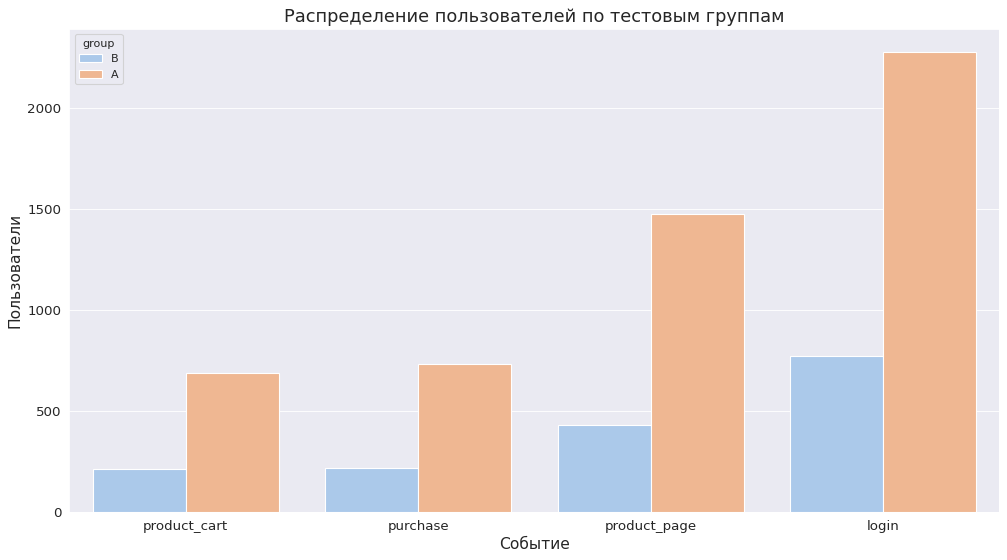

In [30]:
sns.set_palette('pastel')
sns.set_style('darkgrid')

plt.figure(figsize=(15,8), dpi = 80)

event_groups = ab_data.groupby(['group','event_name'],as_index=False).agg({'user_id':'nunique'}).sort_values('user_id')


sns.barplot(data = event_groups, x = 'event_name', y = 'user_id', hue = 'group')
plt.title('Распределение пользователей по тестовым группам',size=16)
plt.ylabel('Пользователи',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Событие',size=14)
plt.show()

Распределение событий между группами отличается значительно.

In [31]:
ab_data.groupby('group',as_index=False).agg({'user_id':'nunique'})

,group,user_id
0,A,3195
1,B,2373


In [32]:
2373 / 3195

0.7427230046948357

Видно, что распределение между группами неравномерное, группа А почти на 25% больше группы В. Это очевидно повлияет на результат теста.

## Исследование данных

In [33]:
event_usrs = ab_data.groupby('group',as_index=False).agg({'event_name':'count'})

event_usrs['events_on_user'] = (event_usrs['event_name'] / ab_data.groupby('group',as_index=False).agg({'user_id':'nunique'})['user_id']).round(2)

event_usrs

,group,event_name,events_on_user
0,A,16154,5.06
1,B,4410,1.86


Среднее число событий на пользователя отличаются значительно. Поведенчески группы между собой явно не равны.

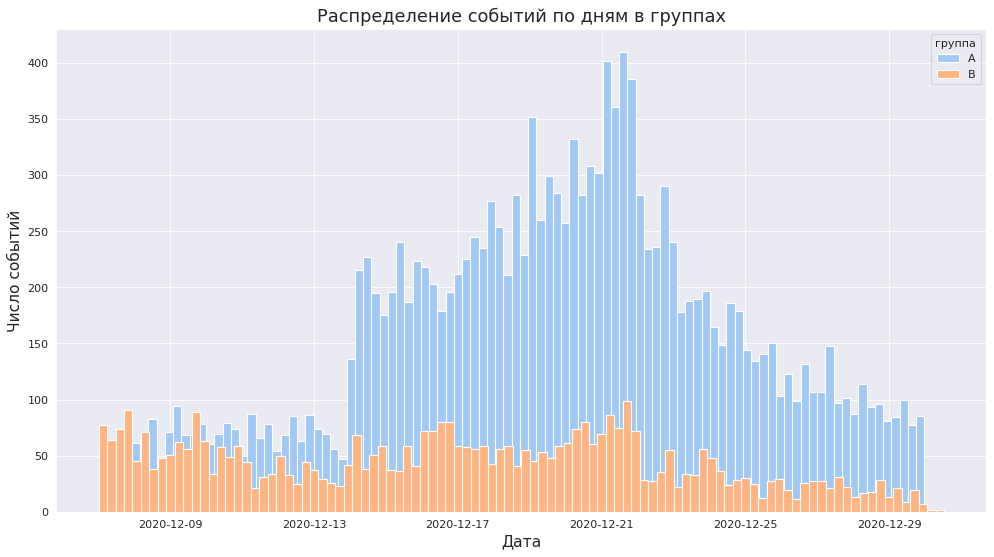

In [34]:
fig, ax = plt.subplots(figsize=(15,8), dpi = 80)

ab_data.query('group=="A"')['event_dt'].hist(bins=100,label='A')

ab_data.query('group=="B"')['event_dt'].hist(bins=100,label='B')

ax.legend(title = 'группа')
plt.xlabel('Дата',size=14)
plt.ylabel('Число событий',size=14)
plt.title('Распределение событий по дням в группах',size=16);

События в группах также распределение по дням разное. С 14 декабря в группе А резко возрастает активность, вероятно, эти пользователи участвовали в какой-то промо акции, о которой нет информации в данных. Группа В распределена относительно равномерно, с небольшими спадами и пиками.

Предположим, цепочка событий выглядит так: login → product_page → product_cart → purchase. Построим воронку событий для групп

In [35]:
grpA = (ab_data
        .query('group == "A"')
        .groupby('event_name',as_index=False)
        .agg({'user_id':'nunique'})
        .sort_values('user_id', ascending = False)
        .reindex([0,2,1,3])
       )

grpB = (ab_data.query('group == "B"')
        .groupby('event_name',as_index=False)
        .agg({'user_id':'nunique'})
        .sort_values('user_id', ascending = False)
        .reindex([0,2,1,3])
       )

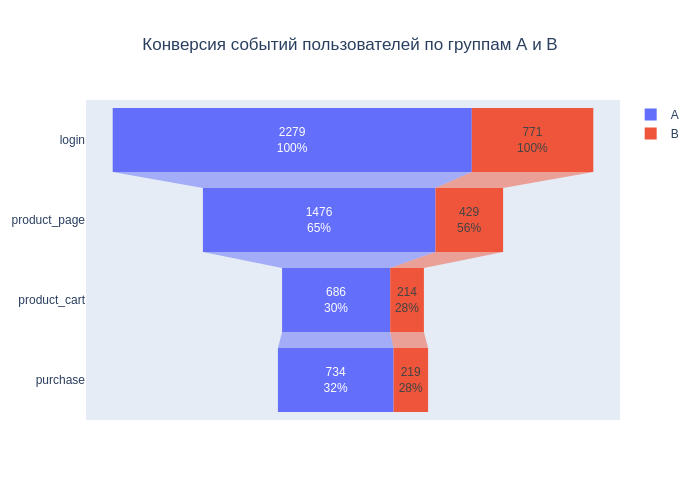

In [36]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = grpA['event_name'],
    x = grpA['user_id'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'B',
    y = grpB['event_name'],
    x = grpB['user_id'],
    textinfo = "value+percent initial"))

fig.update_layout(
    title = {
        'text' : 'Конверсия событий пользователей по группам А и В',
        'x':0.5
    }
)

fig.show()

Конверсии в покупку для обоих групп около 30%, целевой рост группы В на 10% не достигнут. Интересно, что число пользователей с экрана корзины меньше, чем число пользователей, купивших товар. Видимо, покупку можно совершить в обход корзины или имеет место какая-то системная ошибка.

## Оценка результатов А/В теста

In [37]:
#разбивка числа пользователей по событиям и группам
events_grps = ab_data.pivot_table(index='event_name', values='user_id', columns='group', aggfunc='nunique').reset_index()

events_grps

group,event_name,A,B
0,login,2279,771
1,product_cart,686,214
2,product_page,1476,429
3,purchase,734,219


In [38]:
#число пользователей в группах
groups = ab_data.groupby('group',as_index=False).agg({'user_id':'nunique'})

groups

,group,user_id
0,A,3195
1,B,2373


Размеры групп, как уже отмечалось ранее, отличаются. Возможно, были допущены ошибки при разбиении на группы.

In [39]:
#определим функцию для проведения теста на равенство долей
def z_test(group1, group2, event, alpha=0.05):
    #доли пользователей в группах при событии event
    successes1 = events_grps[events_grps['event_name']==event][group1].iloc[0]
    successes2 = events_grps[events_grps['event_name']==event][group2].iloc[0]
    
    #общее количество наблюдений в группах
    trials1 = groups[groups['group']== group1]['user_id'].iloc[0]
    trials2 = groups[groups['group']== group2]['user_id'].iloc[0]
    
    #пропорция успехов в первой группе
    p1 = successes1/trials1

    #пропорция успехов во второй группе
    p2 = successes2/trials2

    #пропорция успехов в комбинированном датасете
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    #разница пропорций в датасетах
    difference = p1 - p2
    
    #считаем статистику в ст.отклонениях стандартного нормального распределения   
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    alpha = alpha / 4 #применим поправку Бонферрони

    #значение p для двухсторонней гипотезы
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница для события", event, 'для групп', group1, 'и', group2)
    else:
        print("Не получилось отвергнуть нулевую гипотезу для события", event, 'для групп', group1, 'и', group2)  

Проверим, есть ли различия между долями пользователей в событии event в контрольных группах. Формулируем гипотезы:

```
H_0: Между долями пользователей групп нет статистических различий.

H_a: Между долями пользователей групп есть статистические различия.
```
Уровень значимости = 0.05

In [40]:
for event in events_grps.event_name.unique():
    z_test('A', 'B', event, 0.05)

p-value:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница для события login для групп A и B
p-value:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница для события product_cart для групп A и B
p-value:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница для события product_page для групп A и B
p-value:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница для события purchase для групп A и B


Статистическая разница видна для всех событий. Но конверсия скорее всего изменилась в сторону уменьшения, как мы видим по воронке событий.

## Общие выводы

По итогу, результаты теста не имеет смысла интерпретировать, начальные данные очень "грязные", пришлось отбросить так как проведение теста можно назвать некорректным по причинам:

* данные по действиям пользователей обрываются 30го декабря 2020, хотя тест должен был идти ещё 5 дней, до 4го января 2021

* данные по регистрациям пользователям имеются с 7 по 23 декабря 2020 года, хотя окончание набора пользователей было запланировано на 21 декабря

* в данных есть пользователи из других регионов помимо EU

* тест recommender_system_test проводился параллельно с конкурирующим тестом interface_eu_test

* в воронках целевой показатель роста конверсии по каждому шагу на 10% не достигнут

* контрольная группа А больше на 25% тестовой группы B

* проведение теста пересекается с промо событием Christmas&New Year Promo

Похоже, что это результат либо ошибок в организации тестирования, либо технического сбоя в сборе данных. Необходимо пересмотреть дизайн теста и обеспечить техническую возможность его проведения. Тщательно подготовить данные, корректно распределить группы пользователей. Также **желательно** не проводить тест в период акций, которые будут очевидно влиять на конверсию, и также не проводить одновременно несколько конкурирующих тестов.